# Introduction

Projet de machine learning de la classe 3 de I1

Réalisé par Bouchier Tristan, Demay Thibault, Prangère Romain, Ruas Maryse

Travail de recherches sur le Kaggle suivant https://www.kaggle.com/c/whats-cooking-kernels-only



# Import et tests du jeu de données

In [ ]:
#Import des librairies
from google.colab import files
import io
import pandas as pd
import os
import json
import re
from matplotlib import pyplot as plt
import seaborn as sns


#Utile pour la lemmatization
from collections import defaultdict
import nltk
from nltk.stem import WordNetLemmatizer

from numpy import around, array, rint, concatenate, vstack, column_stack

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn import pipeline,ensemble,preprocessing,feature_extraction,metrics
from tqdm import tqdm
from math import sqrt
wnl = WordNetLemmatizer()
tqdm.pandas()
nltk.download('wordnet') #Nécessaire pour récupérer le wordnet lematizer dans la lib nltk

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


True

In [ ]:
#Import des trois fichiers fournis avec le kaggle
train             = files.upload()

Saving train.json to train.json


In [ ]:
dataTrain = pd.read_json(train['train.json'])
dataTrain.head()

id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...

In [ ]:
dataTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [ ]:
test              = files.upload()

Saving test.json to test.json


In [ ]:
dataTest = pd.read_json(test['test.json'])
dataTest.head()

id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...

#Représentation du nombre d'ingrédients
Ajout d'une colonne nombre d'ingrédients

In [ ]:
dataTrain['num_ingredients'] = dataTrain['ingredients'].apply(len)
dataTrain.head()

id  ... num_ingredients
0  10259  ...               9
1  25693  ...              11
2  20130  ...              12
3  22213  ...               4
4  13162  ...              20

[5 rows x 4 columns]

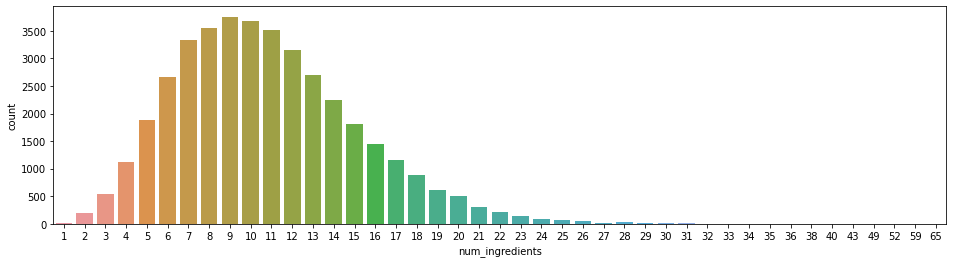

In [ ]:
plt.figure(figsize=(16,4))
sns.countplot(x='num_ingredients', data=dataTrain) 

On supprime toutes les recettes a moins de 4 ingredients par soucis de legitimité des données.

In [ ]:
dataTrainRemoveIndex = [i for i, val in enumerate(dataTrain['num_ingredients']) if val < 4]
dataTrainSave = dataTrain[:]

dataTrain = dataTrainSave.drop(reversed(dataTrainRemoveIndex)) # On commence à la fin pour éviter de recalculer les offsets

On vérifie qu'on a bien conservé que les recettes qui nous interessent

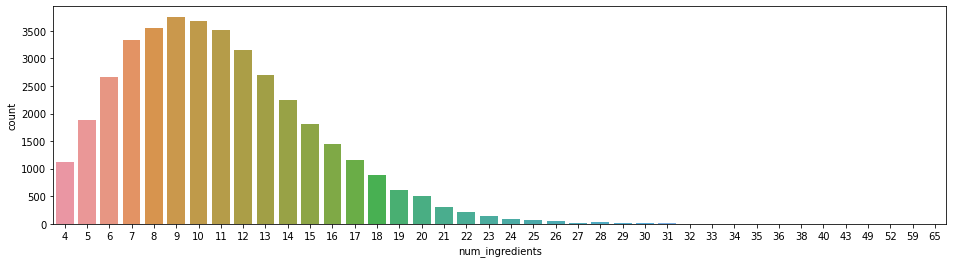

In [ ]:
plt.figure(figsize=(16,4))
sns.countplot(x='num_ingredients', data=dataTrain) 

#Traitement des données
On va retirer certains caractères, retirer les ingrédients anomalies : 2 caractères ou moins, des chiffres, des caractères spéciaux, etc

In [ ]:
def pre_processing_(recipe):    
    wnl = WordNetLemmatizer()
    recipe = [str.lower(ingredient) for ingredient in recipe]
    recipe = [delete_state_(ingredient) for ingredient in recipe]
    recipe = [delete_comma_(ingredient) for ingredient in recipe]
    recipe = [original_(ingredient) for ingredient in recipe]
    recipe = [delete_space_(ingredient) for ingredient in recipe if len(delete_space_(ingredient))>2]
    recipe = transform_string_(recipe)
    return recipe

def transform_string_(recipe):
    string = ' '
    return string.join(recipe)

def delete_state_(ingredient):
    ingredient = re.sub('frozen|chopped|ground|fresh|powdered', '', ingredient)
    ingredient = re.sub('sharp|crushed|grilled|roasted|sliced|dried', '', ingredient)
    ingredient = re.sub('cooked|shredded|cracked|minced|finely', '', ingredient)    
    return ingredient

def delete_comma_(ingredient):
    ingredient = ingredient.split(',')
    ingredient = ingredient[0]
    return ingredient

# Ca ne fonctionne pas ça, il doit y avoir un problème dans l'appel de la méthode
# def keep_ponctuation_(ingredient):
#     ingredient = re.findall(r'\'')[0])
#     ingredient = re.findall(r'\!')[0])
#     return ingredient

def original_(ingredient):
    ingredient = re.sub('[0-9]', '', ingredient)
    ingredient = ingredient.replace("oz.", '')
    ingredient = re.sub('[&%()®™/]', '', ingredient)
    ingredient = re.sub('[-.]', '', ingredient)
    ingredient = wnl.lemmatize(ingredient)
    return ingredient

def delete_space_(ingredient):
    ingredient = ingredient.strip()
    return ingredient

processedDataTrain = dataTrain[:]

processedDataTrain['ingredients_processed'] = processedDataTrain['ingredients'].progress_apply(pre_processing_)

processedDataTest = dataTest[:]
processedDataTest['ingredients_processed'] = dataTest['ingredients'].progress_apply(pre_processing_)


100%|██████████| 39010/39010 [00:07<00:00, 4951.46it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 9944/9944 [00:01<00:00, 6500.83it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
processedDataTrain.head()

id  ...                              ingredients_processed
0  10259  ...  romaine lettuce black olives grape tomatoes ga...
1  25693  ...  plain flour pepper salt tomato black pepper th...
2  20130  ...  egg pepper salt mayonaise cooking oil green ch...
3  22213  ...                     water vegetable oil wheat salt
4  13162  ...  black pepper shallot cornflour cayenne pepper ...

[5 rows x 5 columns]

In [ ]:
processedDataTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39010 entries, 0 to 39773
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     39010 non-null  int64 
 1   cuisine                39010 non-null  object
 2   ingredients            39010 non-null  object
 3   num_ingredients        39010 non-null  int64 
 4   ingredients_processed  39010 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


On réalise deux échantillons de 10% (environ 4000 recettes) chacun, pour faire des entraînements et tests rapides.

In [ ]:
sampleDataTrain = processedDataTrain.sample(frac=0.10)

In [ ]:
sampleDataTest = processedDataTest.sample(frac=0.10)

# Approche RandomForest

On rappelle que la méthode du random forest, de la forêt aléatoire, s'appuie sur l'approche des arbres de décision pour la classification (ou la régression linéaire). On y crée un nombre important d'arbres de décisions, construits à partir de petits échantillonages pris sur le dataset. On va ensuite évaluer la réponse de tous les arbres, la moyenner, et obtenir ainsi une réponse moyenne de toute la forêt pour la classification. C'est parti !

https://www.kaggle.com/tuanndd/random-forest-tfidf

On crée le classifier en précisant le type de technique utilisé

In [ ]:
clfSample=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

On va commencer par entraîner une première forêt sur un échantillon de taille = 10% de l'échantillon total.

In [ ]:
clfSample.fit(sampleDataTrain['ingredients_processed'],sampleDataTrain['cuisine'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.4s finished


Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

In [ ]:
y_pred_randomforest_sample=clfSample.predict(sampleDataTest['ingredients_processed'])



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished


Vrai entraînement avec toute les données (à ne lancer qu'une fois)

In [ ]:
clf=pipeline.Pipeline([
        ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
        ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500,verbose=1,n_jobs=-1))
    ])

In [ ]:
clf.fit(processedDataTrain['ingredients_processed'], processedDataTrain['cuisine'])

In [ ]:
randomForestPred = clf.predict(processedDataTest['ingredients_processed'])


Envoi des données Kaggle

In [ ]:
df=pd.DataFrame({'id':dataTest.id,'cuisine':randomForestPred})

In [ ]:
df.to_csv('rf_tfidf.csv', columns=['id','cuisine'],index=False)

Cette version a été soumise au Kaggle et a obtenu le score de 0.75472.

#Méthode des k plus proches voisins


La méthode de KNN, pour K Nearest Neighbors, ou k plus proche voisins (in english in the text), repose sur une approche situationnelle de la donnée : chaque fois que le modèle doit prédire l'appartenance d'une nouvelle donnée, elle la positionne "géographiquement" dans l'espace à N dimension du problème, et va définir ses N plus proches voisins : les N données qui sont les plus proches de la configuration de la donnée à tester, i.e. dont les variables présentes les écarts les plus faibles, et va déterminer son appartenance par rapport à celles des voisins interrogés. C'est une approche particulièrement utilisée dans les algorithmes de machine learning traitant de données textuelles.

Création des modèles d'essai et final

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=7)

Vectorisation des recettes : il faut transformer la donnée, une liste de string, en un vecteur de très grande dimension (une part mot rencontré).

On crée un globalDataIngredients qui est la concaténation des recettes d'entrainement et de celles à soumettre au kaggle, pour avoir l'unicité dimensionnelle des vecteurs.

In [ ]:
vectorizer = TfidfVectorizer(binary=False)
# vectorizer2 = TfidfVectorizer(binary=False)
# vectorizer3 = TfidfVectorizer(binary=False)
#On configure le vectorizer en prennant comme base l'échantillonnage fixé plus haut
globalDataIngredients = concatenate((processedDataTrain['ingredients_processed'],processedDataTest['ingredients_processed']), axis=0)

vectorizer.fit(globalDataIngredients)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
#On vectorise l'échantillonnage d'entraînement
vector_ingredients = vectorizer.transform(processedDataTrain['ingredients_processed']) 
# vector_ingredients2 = vectorizer2.transform(processedDataTrain['ingredients_processed']) 
# vector_ingredients3 = vectorizer3.transform(processedDataTrain['ingredients_processed']) 
#On vectorise également l'échantillonnage de test selon la même grille de transformation
vector_ingredients_submit = vectorizer.transform(processedDataTest['ingredients_processed'])
# vector_ingredients_submit2 = vectorizer2.transform(processedDataTest['ingredients_processed'])
# vector_ingredients_submit3 = vectorizer3.transform(processedDataTest['ingredients_processed'])
lb = LabelEncoder()
#Vectorisation du vecteur cuisine
vector_cuisine = lb.fit_transform(processedDataTrain['cuisine'])


On segmente notre échantillon en une partie d'entrainement et une partie de test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vector_ingredients,vector_cuisine, test_size=0.01)

Entraînement du modèle

In [ ]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                    weights='uniform')

In [ ]:
#sampleDataTrain.iloc[1][4]

On prédit avec le modèle, on arrondit à l'entier le plus proche, et on fait la transformation inverse pour récupérer le nom de la cuisine.

On commence par évaluer l'erreur en utilisant l'échantillonnage de test.

In [ ]:
knn_pred_test = knn_model.predict(X_test)

In [ ]:
cuisine_pred = lb.inverse_transform((rint(knn_pred).astype(int)))

In [ ]:
mse = mean_squared_error(y_test, knn_pred_test)
rmse = sqrt(mse)
rmse

3.658642823562095

3.6 de rmse pour 10 voisins... Cela semble important, c'est un écart à la réponse qui est de l'ordre de l'entier... au delà de 1, c'est qu'on s'est trompé de catégorie. 

*   3 voisins : rmse = 3.8
*   10 voisins : 3.6
*   20 voisins : 3.6
*   50 voisins : 3.6
*   500 voisins : 4


Prédiction sur l'échantillonnage à soumettre.

In [ ]:
knnPred = knn_model.predict(vector_ingredients_submit)

In [ ]:
cuisine_knn_pred = lb.inverse_transform((rint(knnPred).astype(int)))

In [ ]:
df=pd.DataFrame({'id':processedDataTest['id'],'cuisine':cuisine_knn_pred})

In [ ]:
df.to_csv('rf_knn50.csv', columns=['id','cuisine'],index=False)

Première soumission avec k = 10 voisins concertés : 0.36. On est loin du compte.
Deuxième soumission avec k = 50 voisins concertés : 0.29. Trop de voisins qui interviennent dans la décision nous fausse les résultats.

# Gaussian Naive Bayes

Le modèle de Naive Bayes repose sur des multiplications de probabilités d'appartenir à une classe lorsqu'un attribut prend telle ou telle valeur. Les probabilités sont définis par rapport au jeu d'entraînement, et chaque classification est la comparaison de toutes les combinaisons possibles.

In [ ]:
modelNB = GaussianNB()
modelNB.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
nb_predict = modelNB.predict(vector_ingredients_submit.toarray())

In [ ]:
cuisine_nb_pred = lb.inverse_transform(nb_predict)

In [ ]:
cuisine_nb_pred

array(['jamaican', 'british', 'moroccan', ..., 'cajun_creole',
       'cajun_creole', 'spanish'], dtype=object)

In [ ]:
df=pd.DataFrame({'id':processedDataTest['id'],'cuisine':cuisine_nb_pred})

In [ ]:
df.to_csv('rf_nb.csv', columns=['id','cuisine'],index=False)

Soumission : 0.23

# Conclusion

Nous avons pu tester trois différents algorithmes de machine learning : RandomForest, K plus proche voisins, et Naive Bayes pour notre problématique de classification. Les résultats ont été très significativement supérieurs pour l'approche RandomForest, qui repose sur un ensemble d'arbres de décisions construits aléatoirement. La méthode SVM a quant à elle était utilisée dans le projet Deep Learning, elle n'est donc pas abordée ici.